In [1]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import re
import csv
import os

In [2]:
df_weekly_sum = pd.read_csv('dpgr_who_countries_1.csv')
print(df_weekly_sum)

       Variant                   Date                         Location  Freq
0        Alpha  2019-12-30/2020-01-05  Africa / South Africa / Gauteng     1
1        Alpha  2019-12-30/2020-01-05            Asia / India / Kerala     5
2        Alpha  2019-12-30/2020-01-05        Asia / India / Tamil Nadu     1
3        Alpha  2019-12-30/2020-01-05                          Austria     4
4        Alpha  2019-12-30/2020-01-05                  Europe / Cyprus    21
...        ...                    ...                              ...   ...
83732  Omicron  2022-05-30/2022-06-05                      South Korea     3
83733  Omicron  2022-05-30/2022-06-05                            Spain   177
83734  Omicron  2022-05-30/2022-06-05                           Sweden     6
83735  Omicron  2022-05-30/2022-06-05                      Switzerland    69
83736  Omicron  2022-05-30/2022-06-05                              USA  4135

[83737 rows x 4 columns]


# Original One

In [3]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron','Epsilon','Lambda','Iota','Kappa','Mu','Eta','Zeta','Theta']
# VOC = ['Delta', 'Omicron']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
def create_distance_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    distance_matrix = pd.DataFrame(index = clade_list)
    distance_matrix[clade_list] = np.nan
    #fill in distance matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                distance_matrix.loc[i,j] = 0
            else:
                distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    return distance_matrix

#function to generate difference matrix based on quarter, year, and continent
def create_difference_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    difference_matrix = pd.DataFrame(index = clade_list)
    difference_matrix[clade_list] = np.nan
    #fill in difference matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                difference_matrix.loc[i,j] = 0
            else:
                difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    #if row_vs_col is a negative value, make it negative in difference matrix
    for i,v in difference_matrix.iterrows():
        for j in difference_matrix:
            if i != j:
                if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
                    difference_matrix.loc[i,j] *= -1
    return difference_matrix

#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)

def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]

    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

*when using the scatterplot function use the original one to create the scatterplots*

In [4]:
def scatterplot(country, dataset, start, end, variant):
    
    df_weekly = dataset[dataset['Location'] == country]
    

    #pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index = 'Date', columns = 'Variant', values = 'Freq')
    df_weekly = df_weekly.reset_index()
    

    df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])
#     print(df_weekly.head())
    #split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
#     print(tmp.head())
    tmp.columns = ['0','1','2','3']
#     print(tmp.head())

    #collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
#     print(df_weekly.head())
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
           
    #specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
#     df_sum.to_csv(r'df_sum.csv')
#     print(df_sum)
    #calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
#     print(df_)
    # df_.to_csv(country+'_clade_comparison')
    df_['days'] -= df_['days'].iloc[0]
    #print(df_)
 

    #scatterplot of omicron BA.1 lineage fitness
    sns.set_style("white")
    sns.set(rc = {'figure.figsize':(3,3)})
#     plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.9)
    pango_compare = [variant] #'Omicron', 'Delta', 'Gamma', 'Beta', 'Alpha'
    marker = ['.', '+', 'v', 'x','*']
    legend=[]
    c=0
    # Create a list to store the slope values and corresponding locations
    slope_values = []
    
    for i in pango_compare:
        if i != 'Delta': #and i!='Alpha' and i != 'Gamma':# and i!='Delta' and i!='Beta':
            
            mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Delta vs {0}'.format(i)])
            slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask],df_['Delta vs {0}'.format(i)][mask])
#             print('test')
#             print(slope)
#             print(intercept)
            slope_values.append((country, slope))  # Append tuple of location and slope value
            print(slope_values)
            sns.regplot(x=df_['days'], y=df_['Delta vs {0}'.format(i)], marker=marker[c],scatter_kws={'s':50},label='Delta vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color = 'red')
            # legend.append('BA.5 vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
        c+=1
        
    '''
    #Save the slope values of corresponding countries to a CSV file
    # Define the file path to save the CSV
    csv_file = 'Omicron_Vs_delta_negative_slope_values_countries.csv'

    # Append the slope values to the CSV file
    with open(csv_file, 'a', newline='') as file:
        writer = csv.writer(file)
        if file.tell() == 0:
            writer.writerow(['Location', 'Slope'])  # Write the header row if the file is empty
        writer.writerows(slope_values)  # Append the slope values

    print('Slope values saved to', csv_file)
    '''
    
#     plt.legend(loc='upper left', prop={'size': 11}, facecolor='white', fontsize = 8) 
    plt.legend(loc='upper left', prop={'size': 6}, facecolor='white', frameon=False)
    plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant\ 1}}{\mathrm{Variant\ 2}}\right)$', fontsize=7.5, labelpad=1)
#     plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant}_1}{\mathrm{Variant}_2}\right)$', fontsize=8)
    plt.title(f'Delta vs Omicron\n Time Window: ({start}) - ({end})\nLocation : {country}', fontsize=7.5)
    plt.xlabel('Days', fontsize = 7.5)  # Set x-axis label and adjust font size
    plt.rc('axes', labelsize=7.5)  # Adjust the label font size
    plt.rc('xtick', labelsize=7.5)
    plt.rc('ytick', labelsize=7.5)
    plt.gca().set_facecolor('white')  # Set plot background color to white
    

   
    # Add vertical bars for x-axis and y-axis without changing the range
    plt.axhline(y=plt.ylim()[0], color=(0, 0, 0.1))  # Vertical bar for y-axis
    plt.axvline(x=plt.xlim()[0], color=(0, 0, 0.1))  # Vertical bar for x-axis
 
    
    #Save the figures to `omicron_vs_delta_regression_plots` folder
    import os

    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_negative_regression_plots/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, country + "_regression_Omicron_vs_delta_negative.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # plt.savefig(country+"_slope"+'.png')

# Negative Regression plots `(Country level)` for `Delta Vs. Omicron`

['2022-03', '2022-04', '2022-05']
[('USA', -0.008394026595098511)]


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

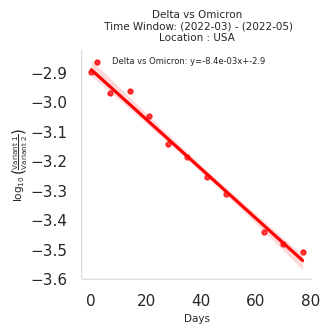

In [5]:
scatterplot('USA', df_weekly_sum, start = '2022-03', end = '2022-05', variant = 'Omicron')  #you can pass a list of variants to compare

['2021-11', '2021-12']
[('Turkey', -0.10112420545765761)]


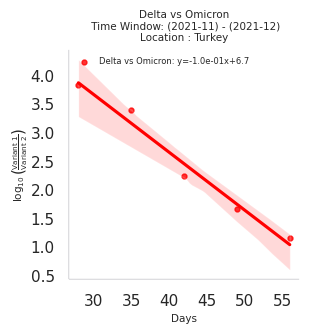

In [6]:
scatterplot('Turkey', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-11', '2021-12']
[('Israel', -0.07490155865596644)]


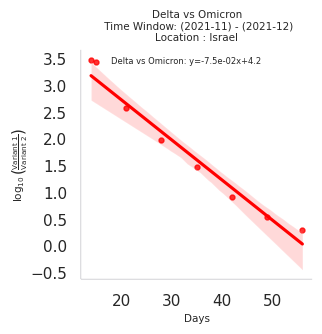

In [7]:
scatterplot('Israel', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-11', '2021-12']
[('Italy', -0.07431804774301876)]


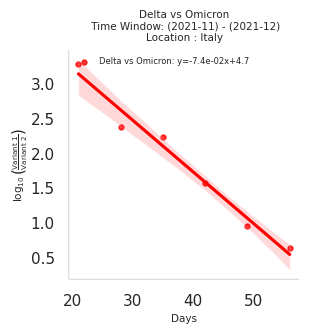

In [8]:
scatterplot('Italy', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-11', '2021-12']
[('Spain', -0.06780974027954317)]


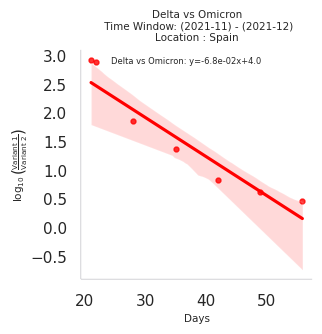

In [9]:
scatterplot('Spain', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-11', '2021-12']
[('Ireland', -0.07342958825234402)]


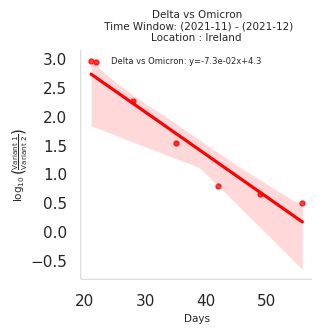

In [10]:
scatterplot('Ireland', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-11', '2021-12']
[('France', -0.0612355483901909)]


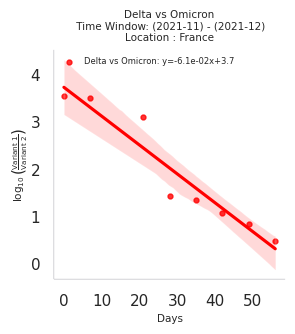

In [11]:
scatterplot('France', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-12', '2022-01']
[('Germany', -0.0291975838004124)]


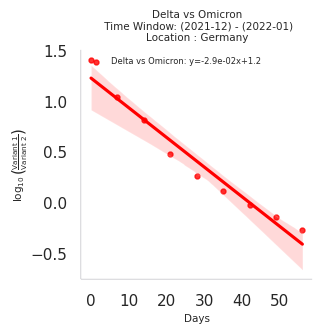

In [12]:
scatterplot('Germany', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Omicron')

['2021-12', '2022-01']
[('Denmark', -0.027674745702803125)]


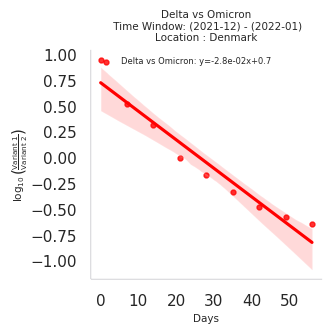

In [13]:
scatterplot('Denmark', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Omicron')

['2021-11', '2021-12', '2022-01']
[('South Korea', -0.0359470373161788)]


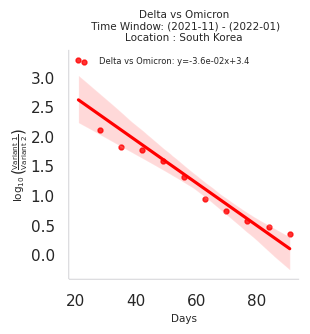

In [14]:
scatterplot('South Korea', df_weekly_sum, start = '2021-11', end = '2022-01', variant = 'Omicron')

['2021-11', '2021-12']
[('France', -0.0612355483901909)]


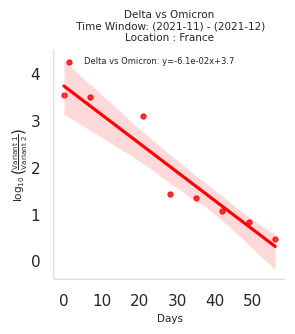

In [15]:
scatterplot('France', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-12', '2022-01']
[('Japan', -0.04016685544360124)]


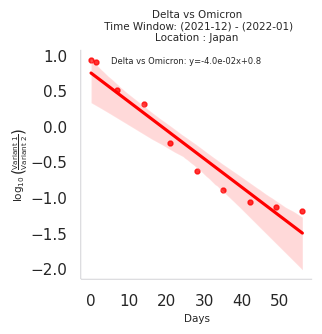

In [16]:
scatterplot('Japan', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Omicron')

['2021-11', '2021-12']
[('Netherlands', -0.058998029063608105)]


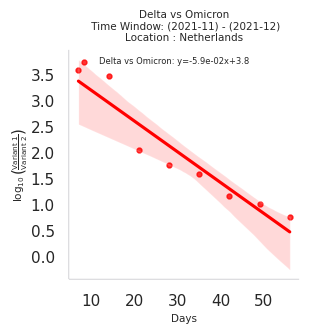

In [17]:
scatterplot('Netherlands', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-11', '2021-12']
[('Switzerland', -0.07136890825380295)]


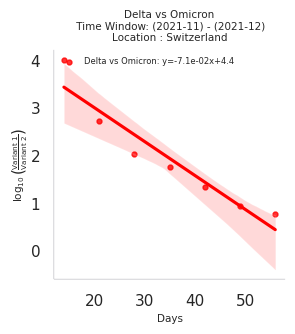

In [18]:
scatterplot('Switzerland', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-11', '2021-12']
[('Poland', -0.095231595784638)]


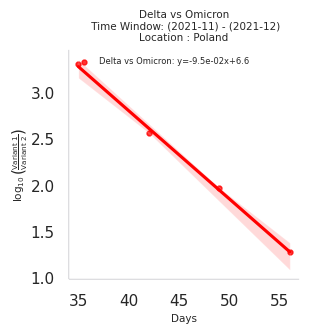

In [19]:
scatterplot('Poland', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-11', '2021-12']
[('Mexico', -0.0708878064028956)]


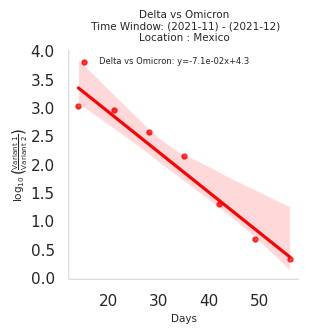

In [20]:
scatterplot('Mexico', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-11', '2021-12']
[('Brazil', -0.07665001171846936)]


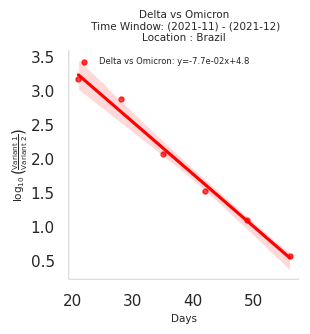

In [21]:
scatterplot('Brazil', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-11', '2021-12']
[('Canada', -0.06875782180615861)]


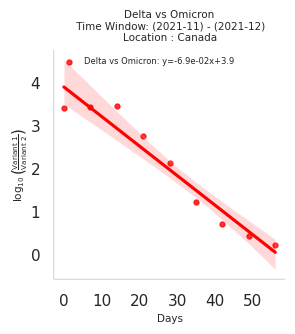

In [22]:
scatterplot('Canada', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Omicron')

['2021-12', '2022-01']
[('Belgium', -0.02390055267045942)]


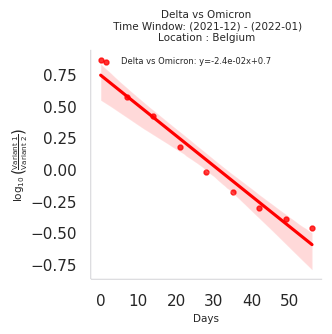

In [23]:
scatterplot('Belgium', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Omicron')

# `Bar Plot` of the slope values in diffeerent `Countries`

In [24]:
slope_values_of_countries = pd.read_csv('Omicron_Vs_delta_negative_slope_values_countries.csv')
print(slope_values_of_countries)

       Location     Slope
0           USA -0.008394
1        Turkey -0.101124
2        Israel -0.074902
3         Italy -0.074318
4         Spain -0.067810
5       Ireland -0.073430
6        France -0.061236
7       Germany -0.029198
8       Denmark -0.027675
9   South Korea -0.035947
10       France -0.061236
11        Japan -0.040167
12  Netherlands -0.058998
13  Switzerland -0.071369
14       Poland -0.095232
15       Mexico -0.070888
16       Brazil -0.076650
17       Canada -0.068758
18      Belgium -0.023901


In [25]:
slope_values_of_countries = slope_values_of_countries.drop_duplicates()
print(slope_values_of_countries.describe())
print("\n")

# Find the minimum and maximum slope values
min_slope_value = slope_values_of_countries['Slope'].min()
max_slope_value = slope_values_of_countries['Slope'].max()

# Find the corresponding countries for the minimum and maximum slope values
min_slope_countries = slope_values_of_countries[slope_values_of_countries['Slope'] == min_slope_value]['Location']
max_slope_countries = slope_values_of_countries[slope_values_of_countries['Slope'] == max_slope_value]['Location']

# Print the results
print(f"Min Slope Value: {min_slope_value}")
print(f"Country: {', '.join(min_slope_countries)}")
print("\n")
print(f"Max Slope Value: {max_slope_value}")
print(f"Country: {', '.join(max_slope_countries)}")
print("\n")
print(f"Average Slope Value: {slope_values_of_countries['Slope'].mean()}")


           Slope
count  18.000000
mean   -0.058889
std     0.025570
min    -0.101124
25%    -0.074096
50%    -0.068284
75%    -0.037002
max    -0.008394


Min Slope Value: -0.1011242054576576
Country: Turkey


Max Slope Value: -0.0083940265950985
Country: USA


Average Slope Value: -0.05888853685204704


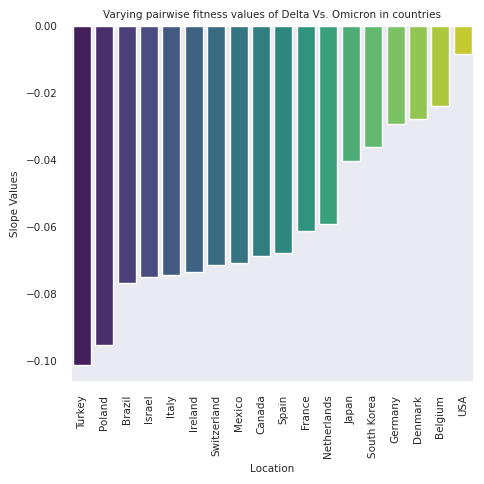

In [26]:
# Sort the DataFrame by 'Slope' column in ascending order
slope_values_of_countries = slope_values_of_countries.sort_values('Slope', ascending=True)

# Define the color palette
color_palette = sns.color_palette('viridis', len(slope_values_of_countries))

# Plot the bar plot with the specified color palette
plt.figure(figsize=(5, 5))
sns.barplot(x='Location', y='Slope', data=slope_values_of_countries, palette=color_palette)
plt.xlabel('Location', fontsize = 7.5)
plt.ylabel('Slope Values', fontsize = 7.5)
plt.title('Varying pairwise fitness values of Delta Vs. Omicron in countries', fontsize = 7.5)
plt.xticks(rotation=90)
plt.grid(False)  # Turn off the grid lines
plt.tight_layout()

# Specify the directory path
directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_negative_regression_plots/"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the figure to the specified directory with DPI set to 300
filename = os.path.join(directory, "countries_bar_plot_Omicron_vs_delta_negative.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

# Display the figure
plt.show()
